In [1]:
import sys
!{sys.executable} -m pip install bs4
!{sys.executable} -m pip install lxml
!pip install geopy

     |████████████████████████████████| 122kB 6.1MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
     |████████████████████████████████| 5.5MB 5.1MB/s eta 0:00:01█▍            | 3.4MB 5.1MB/s eta 0:00:01
     |████████████████████████████████| 112kB 6.8MB/s eta 0:00:01


In [33]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from lxml import html
import urllib
from urllib.request import urlopen
import json
import numpy as np
import codecs
from lxml import etree
import re
from math import sqrt

In [3]:
#url = "https://www.codiciavviamentopostale.it/cap-milano.html"
url = "http://www.omarpela.com/milano/cap-codice-di-avviamento-postale-vie-milano.html"

In [4]:
html_file = requests.get(url).text
soup = BeautifulSoup(html_file, 'html.parser')
#print(soup.prettify())

In [5]:
content = soup.find_all('pre')

In [6]:
street_list = []

for item in content: #loop and find content of the item
    content_t = item.contents
    #print(content_t)
    street_list.append(content_t[0].split("\r\n")) #separate each street using the string "\r\n" as separator and create a new list
    
#street_list[0]

In [7]:
milan_street_t = []
milan_postal_code = []

for l in street_list:
    for street in l:
        if (str(20) and "(") in street: #condition for excluding items which don't contain a zip code or a parenthesis (thus "Via" or "Piazza" or etc...)
            pc, s = street.split(" ", 1) 
            s = s.replace(")", "")
            milan_street_t.append(s)
            milan_postal_code.append(pc)
        
milan_street_t[0:10]

['ABAMONTI G. (Via privata',
 'ABANO (Via privata',
 'ABBA G. C. (Via',
 'ABBADESSE (Via',
 'ABBAZIA (Via',
 'ABBIATEGRASSO (Piazza',
 'ABBIATI F. (Via',
 'ABETI (Via degli',
 'ABETONE (Via',
 'ABRUZZI (Viale']

In [8]:
vowels = ['A', 'E', 'I', 'O', 'U', 'a', 'e', 'i', 'o', 'u']

for index, street in enumerate(milan_street_t):
    if "S. " in street:
        t1, t2 = street.split("S. ")
        if t2[0] in vowels:
            milan_street_t[index] = street.replace("S. ", "Sant'")
        else:
            milan_street_t[index] = street.replace("S.", "San")
        #print(milan_street_t[index])
milan_street_t[0:10]

['ABAMONTI G. (Via privata',
 'ABANO (Via privata',
 'ABBA G. C. (Via',
 'ABBADESSE (Via',
 'ABBAZIA (Via',
 'ABBIATEGRASSO (Piazza',
 'ABBIATI F. (Via',
 'ABETI (Via degli',
 'ABETONE (Via',
 'ABRUZZI (Viale']

In [9]:
milan_street = []

for street in milan_street_t:
    position_space = street.find(" ")
    
    try:
        m1, m2 = street.split(" (", 1) # split on " ("
        #print(m1)
        
        try:
            m2, t = m2.split(" ", 1) #remove additional information, such as "privata"
        except:
            pass # if there is no additional information, it passes and proceeds with the remaining code
        
        if "." in m1:
            position_dot = m1.find(".")
            m1 = m1[0:position_dot - 2] # remove the dot, previous capital letter and blank space
        else:
            pass

        street_t = m2 + " " + m1.capitalize()#[0:position_space + 1].capitalize()# + m1[position_space] + m1[position_space + 1::].capitalize()
        milan_street.append(street_t)
    
    except ValueError: # in case there is no " (", instead it splits "("
        m1, m2 = street.split("(", 1)
        
        if "." in m1:
            position_dot = m1.find(".")
            m1 = m1[0:position_dot - 2] # remove the dot, previous capital letter and blank space
        else:
            pass
        #street_t = m2 + " " + m1[0:position_space].capitalize()
        street_t = m2 + " " + m1[0:position_dot - 1].capitalize()
        milan_street.append(street_t)
   
    except ValueError:
        pass

milan_street[0:10]

['Via Abamonti',
 'Via Abano',
 'Via Abba',
 'Via Abbadesse',
 'Via Abbazia',
 'Piazza Abbiategrasso',
 'Via Abbiati',
 'Via Abeti',
 'Via Abetone',
 'Viale Abruzzi']

In [10]:
df_milan = pd.DataFrame({"Location Name": milan_street, "Postal Code": milan_postal_code})

df_milan.head()

,Location Name,Postal Code
0,Via Abamonti,20129
1,Via Abano,20131
2,Via Abba,20158
3,Via Abbadesse,20124
4,Via Abbazia,20125


In [11]:
# adding the geographic coordinates of each street
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent = "Milan_agent")

In [ ]:
milan_latitude = []
milan_longitude = []

for i, street in enumerate(milan_street):
    print(i)
    address = street + " Milano"
    location = geolocator.geocode(query = address, language = "it")
    try:
        latitude = location.latitude
        longitude = location.longitude
        milan_latitude.append(latitude)
        milan_longitude.append(longitude)
    except AttributeError:
        milan_latitude.append("na")
        milan_longitude.append("na")

In [ ]:
df_coordinates = pd.DataFrame({"latitude": milan_latitude, "longitude": milan_longitude})

In [ ]:
dict_milan = {"street_name": milan_street, "postal_code": milan_postal_code, "latitude": milan_latitude, "longitude": milan_longitude}

with open("df_milan.txt", "w") as f:
    json.dump(dict_milan, f)
f.close

In [28]:
!pip install Folium
import folium

In [14]:
with open("df_milan.txt") as f:
    dict_milan = json.load(f)

In [15]:
df_milan = pd.DataFrame.from_dict(dict_milan)
df_milan.head()

,street_name,postal_code,latitude,longitude
0,Via Abamonti,20129,na,na
1,Via Abano,20131,45.4871,9.23175
2,Via Abba,20158,45.54,9.11207
3,Via Abbadesse,20124,45.4899,9.19622
4,Via Abbazia,20125,45.501,9.19848


In [16]:
pc_origin = df_milan["postal_code"].unique()
pc_origin.shape

(41,)

In [17]:
df_milan = df_milan[df_milan["latitude"] != "na"] # remove the streets without latitude (and longitude)
df_milan = df_milan[(df_milan["postal_code"] != "20197") & (df_milan["postal_code"] != "20100")] # remove the line with Postal Code of 20197 and 20100

In [18]:
df_milan.head()

,street_name,postal_code,latitude,longitude
1,Via Abano,20131,45.4871,9.23175
2,Via Abba,20158,45.54,9.11207
3,Via Abbadesse,20124,45.4899,9.19622
4,Via Abbazia,20125,45.501,9.19848
5,Piazza Abbiategrasso,20142,45.4301,9.1783


In [19]:
df_milan["latitude"].astype(float)
df_milan["longitude"].astype(float)

1         9.231747
2         9.112066
3         9.196221
4         9.198485
5         9.178300
           ...    
3932    131.003368
3933      9.158470
3934      7.673935
3935      9.116511
3936      9.324548
Name: longitude, Length: 3342, dtype: float64

In [20]:
lat_min = 45.38877
lat_max = 45.53590

long_min = 9.06597
long_max = 9.29113

In [21]:
df_milan = df_milan[(df_milan["latitude"] < lat_max) & (df_milan["latitude"] > lat_min) & (df_milan["longitude"] < long_max) & (df_milan["longitude"] > long_min)]
#df_milan = df_milan[(df_milan["latitude"] < lat_max)]
df_milan.head()

,street_name,postal_code,latitude,longitude
1,Via Abano,20131,45.4871,9.23175
3,Via Abbadesse,20124,45.4899,9.19622
4,Via Abbazia,20125,45.501,9.19848
5,Piazza Abbiategrasso,20142,45.4301,9.1783
8,Via Abetone,20137,45.4547,9.22677


In [22]:
postal_code = list(df_milan["postal_code"].unique())

In [23]:
average_position = {}

for pc in postal_code:
    df_t = df_milan[df_milan["postal_code"] == pc]
    lat_t = df_t["latitude"].mean()
    lon_t = df_t["longitude"].mean()
    
    average_position[pc] = [lat_t, lon_t]
    
average_position

{'20131': [45.4827249047619, 9.213739547619046],
 '20124': [45.479365003333335, 9.190623514372927],
 '20125': [45.50077073088234, 9.208214514877948],
 '20142': [45.43407586704544, 9.156282774793446],
 '20137': [45.45276132941176, 9.222544755033192],
 '20155': [45.49496546666667, 9.153605685714286],
 '20158': [45.500187509677424, 9.169216953118175],
 '20151': [45.492578519999995, 9.117873272500002],
 '20128': [45.51216915833333, 9.231653116666667],
 '20162': [45.51599237727273, 9.19904074090909],
 '20123': [45.46307202065216, 9.179151934261112],
 '20161': [45.52118438400001, 9.169804968],
 '20149': [45.476405625000005, 9.147394908964424],
 '20141': [45.433456814999985, 9.19374339361734],
 '20121': [45.47148248333334, 9.189625212526073],
 '20127': [45.49851459090909, 9.224422349999998],
 '20148': [45.48057807090907, 9.139853624682104],
 '20159': [45.49619984400002, 9.189322089000001],
 '20156': [45.49978357058825, 9.133266152941175],
 '20153': [45.473396375, 9.104193514156387],
 '20152':

In [24]:
# calculate the center of Milan
lattot = 0
longtot = 0

for pos in average_position:
    lattot = lattot + average_position[pos][0]
    longtot = longtot + average_position[pos][1]

center = [lattot/len(average_position), longtot/len(average_position)]
center

[45.47711253524773, 9.181605716809544]

In [29]:
milan_map = folium.folium.Map(location = center, zoom_start = 12)

lat1_min = 45.45
lat1_max = 45.481
lon1_min = 9.164
lon1_max = 9.207

for cap in average_position:
    if (average_position[cap][0] < lat1_max and average_position[cap][0] > lat1_min) and (average_position[cap][1] < lon1_max and average_position[cap][1] > lon1_min):
        folium.Circle(location=[average_position[cap][0], average_position[cap][1]], popup = str(cap), fill_color='red', radius=500, weight=2, color="red").add_to(milan_map)
        folium.Marker(location = [average_position[cap][0], average_position[cap][1]], popup = str(cap)).add_to(milan_map)
    else:
        folium.Circle(location=[average_position[cap][0], average_position[cap][1]], popup = str(cap), fill_color='red', radius=800, weight=2, color="red").add_to(milan_map)
        folium.Marker(location = [average_position[cap][0], average_position[cap][1]], popup = str(cap)).add_to(milan_map)
    
milan_map

In [30]:
pc0 = postal_code[0]

colors = ["red", "blue", "green", "purple", "orange", "black", "gray"]#, "darkred", "lightred", "beige", "darkblue", "darkgreen", "cadetblue", "darkpurple", "pink", "lightblue", "lightgreen", "lightgray"]
milan_map = folium.folium.Map(location = center, zoom_start = 12)

count = 0

for pc in postal_code:
    if count >= len(colors):
        count = 0
    
    for index, row in df_milan[df_milan["postal_code"] == pc].iterrows():
        folium.Circle(location = [row["latitude"], row["longitude"]], fill_color=colors[count], popup = str(pc), radius=20, weight=2, color=colors[count]).add_to(milan_map)
    count += 1

In [35]:
max_radius = 4 # kilometers
conversion_factor = 110.574 # delta lat/lon in km

street_distance = {"street_name": [], "postal_code": [], "distance": []}

for pc in average_position:
     for index, row in df_milan[df_milan["postal_code"] == pc].iterrows():
        delta_lat = (average_position[pc][0] - float(row["latitude"]))*conversion_factor
        delta_lon = (average_position[pc][1] - float(row["longitude"]))*conversion_factor
        distance = sqrt(delta_lat*delta_lat + delta_lon*delta_lon)
        street_distance["distance"].append(distance)
        street_distance["street_name"].append(row["street_name"])

In [36]:
df_distance = pd.DataFrame(street_distance, columns = ["street_name", "distance"])

In [37]:
df_distance.head()

,street_name,distance
0,Via Abano,2.049378
1,Via Accademia,1.609946
2,Via Arqua',1.927171
3,Piazza Aspromonte,0.630462
4,Via Astolfo,2.181166


In [38]:
df_milan2 = df_milan.merge(df_distance, how = "left", on = "street_name")
df_milan2.shape

(1478, 5)

In [39]:
# limit radius
radius = 1.5
df_milan2 = df_milan2[df_milan2["distance"] < radius]

In [40]:
average_position2 = {}

for pc in postal_code:
    df_t = df_milan2[df_milan2["postal_code"] == pc]
    lat_t = df_t["latitude"].mean()
    lon_t = df_t["longitude"].mean()
    av_radius = df_t["distance"].mean()
    
    average_position2[pc] = [lat_t, lon_t, av_radius]
    
average_position2

{'20131': [45.48644879999999, 9.2215391, 0.9932987961636478],
 '20124': [45.48578969333334, 9.195480299999998, 1.099668660789577],
 '20125': [45.49970514687499, 9.206105693749999, 0.9173826835797745],
 '20142': [45.43522689047619, 9.15639454285714, 0.8683157967517987],
 '20137': [45.45300208181817, 9.221874474882686, 0.5574524753160743],
 '20155': [45.493337455, 9.15615389, 0.5511970283563967],
 '20158': [45.50013280666667, 9.169745181555449, 0.6449431862810241],
 '20151': [45.495242942857146, 9.11834867142857, 1.0947557287650143],
 '20128': [45.51211502727273, 9.2299508, 0.733517735876007],
 '20162': [45.515428790476186, 9.19755029047619, 0.8585909299177145],
 '20123': [45.46157516823529, 9.179898255906144, 0.7245365138150097],
 '20161': [45.522762997727284, 9.169556256818181, 0.862310842147],
 '20149': [45.47605389090909, 9.150224456863812, 0.7291676949476126],
 '20141': [45.436177046153844, 9.194148270949752, 0.9247606508525864],
 '20121': [45.47146893164558, 9.188793053825192, 0.71

In [41]:
pc_t = []
lat_t = []
lng_t = []
rad_t = []

for pc in average_position2.keys():
    pc_t.append(pc)
    lat_t.append(average_position2[pc][0])
    lng_t.append(average_position2[pc][1])
    rad_t.append(average_position2[pc][2])

df_milan_neighbours = pd.DataFrame({"postal code": pc_t, "latitude": lat_t, "longitude": lng_t, "radius": rad_t})
df_milan_neighbours.head()

,postal code,latitude,longitude,radius
0,20131,45.486449,9.221539,0.993299
1,20124,45.485790,9.195480,1.099669
2,20125,45.499705,9.206106,0.917383
3,20142,45.435227,9.156395,0.868316
4,20137,45.453002,9.221874,0.557452


In [42]:
milan_map4 = folium.folium.Map(location = center, zoom_start = 12)

for cap in average_position2:
    folium.Circle(location=[average_position2[cap][0], average_position2[cap][1]], popup = str(cap), fill_color='red', radius=(float(average_position2[cap][2])*1000), weight=2, color="red").add_to(milan_map4)
    #folium.Marker(location = [average_position2[cap][0], average_position2[cap][1]], popup = str(cap)).add_to(milan_map4)
    
milan_map4

In [43]:
CLIENT_ID = 'QMV2FFETPVLE2TKKMSJ4JSSUJXQ1DHRH4YGRHJPOGHVRTF4H' # your Foursquare ID
CLIENT_SECRET = 'FQYCHIUUFNX1R4SGJRV43WBRVFLWVH0IXS4WSWVRCTOZKAZY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [45]:
p_code = []
av_name = []
av_category = []
latitude = []
longitude = []

for pc in average_position2.keys():
    
    lat = average_position2[pc][0]
    lon = average_position2[pc][1]
    radius = average_position2[pc][2]*1000
    
    url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}".format(CLIENT_ID, CLIENT_SECRET, lat, lon, VERSION, radius, LIMIT)
    response = requests.get(url).json()["response"]["groups"][0]["items"]
    
    for item in response:
    
        p_code.append(pc)
        av_name.append(item["venue"]["name"])
        av_category.append(item["venue"]["categories"][0]["name"])
        latitude.append(item["venue"]["location"]["lat"])
        longitude.append(item["venue"]["location"]["lng"])

In [46]:
df_milan_v = pd.DataFrame({"postal_code": p_code, "avenue_name": av_name, "avenue_category": av_category, "latitude": latitude, "longitude": longitude})
df_milan_v.head()

,postal_code,avenue_name,avenue_category,latitude,longitude
0,20131,Mao Hunan Restaurant,Chinese Restaurant,45.486089,9.218781
1,20131,Sakura 2,Japanese Restaurant,45.486115,9.223089
2,20131,Maoji Street Food,Chinese Restaurant,45.483809,9.219316
3,20131,Jubin II,Chinese Restaurant,45.487542,9.218629
4,20131,Flying Tiger,Gift Shop,45.484686,9.215347


In [47]:
restaurants = ["Postal code", "Abruzzo Restaurant", 'African Restaurant', 'American Restaurant', 'Argentinian Restaurant', 'Asian Restaurant', 'BBQ Joint', 'Belgian Restaurant','Bistro','Brazilian Restaurant','Buffet','Burger Joint','Campanian Restaurant','Chinese Restaurant','Dim Sum Restaurant','Diner','Eastern European Restaurant','Fast Food Restaurant','Filipino Restaurant','Food Truck','French Restaurant','Fried Chicken Joint','Greek Restaurant','Hawaiian Restaurant','Hot Dog Joint','Indian Restaurant','Italian Restaurant','Japanese Restaurant','Kebab Restaurant','Korean Restaurant','Kosher Restaurant','Latin American Restaurant', 'Lebanese Restaurant','Mediterranean Restaurant','Mexican Restaurant','Middle Eastern Restaurant','Modern European Restaurant','Mongolian Restaurant','Moroccan Restaurant','Noodle House','Pizza Place','Puglia Restaurant','Ramen Restaurant','Restaurant','Russian Restaurant','Sardinian Restaurant','Seafood Restaurant','Sicilian Restaurant','South American Restaurant','Spanish Restaurant','Sri Lankan Restaurant','Sushi Restaurant','Szechuan Restaurant','Tapas Restaurant','Thai Restaurant','Trattoria/Osteria','Turkish Restaurant','Tuscan Restaurant','Vegetarian / Vegan Restaurant','Vietnamese Restaurant']
restaurants = pd.Series(restaurants)

In [48]:
df_milan_restaurants = df_milan_v[df_milan_v["avenue_category"].isin(restaurants)].reset_index(drop = True)
df_milan_restaurants.head()

,postal_code,avenue_name,avenue_category,latitude,longitude
0,20131,Mao Hunan Restaurant,Chinese Restaurant,45.486089,9.218781
1,20131,Sakura 2,Japanese Restaurant,45.486115,9.223089
2,20131,Maoji Street Food,Chinese Restaurant,45.483809,9.219316
3,20131,Jubin II,Chinese Restaurant,45.487542,9.218629
4,20131,Trattoria Da Abele,Trattoria/Osteria,45.490205,9.220298


In [49]:
import json
import folium
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

In [50]:
# load the dictionary containing geographic coordinates of Milan neighbours

with open("milan_neighbours.json") as f1:
    milan_neighbours = json.load(f1)

In [51]:
# creation of the dataframe containing coordinates of Milan neighbours

df_milan_neighbours = pd.DataFrame.from_dict(milan_neighbours)
df_milan_neighbours.head()

,postal code,latitude,longitude,radius
0,20131,45.486449,9.221539,0.993299
1,20124,45.485790,9.195480,1.099669
2,20125,45.499705,9.206106,0.917383
3,20142,45.435227,9.156395,0.868316
4,20137,45.453002,9.221874,0.557452


In [52]:
# loading the dictionary containing data of the restaurants

with open("milan_restaurants.json", "r") as f2:
    milan_restaurants = json.load(f2)

In [53]:
# creation of the dataframe containing coordinates of Milan restaurants

df_milan_restaurants = pd.DataFrame.from_dict(milan_restaurants)
df_milan_restaurants.head()

,postal code,avenue name,avenue category,latitude,longitude
0,20131,Mao Hunan Restaurant,Chinese Restaurant,45.486089,9.218781
1,20131,Sakura 2,Japanese Restaurant,45.486115,9.223089
2,20131,Maoji Street Food,Chinese Restaurant,45.483809,9.219316
3,20131,Jubin II,Chinese Restaurant,45.487542,9.218629
4,20131,Trattoria Da Abele,Trattoria/Osteria,45.490205,9.220298


In [54]:
# removing category of location "restaurant"

df_milan_restaurants = df_milan_restaurants[df_milan_restaurants["avenue category"] != "Restaurant"]

In [55]:
# removing duplicates from the dataframe

df_milan_restaurants = df_milan_restaurants.drop_duplicates()

In [56]:
# one hot encoding of the Dataframe

milan_onehot = pd.get_dummies(df_milan_restaurants["avenue category"])
milan_onehot.head()

milan_onehot["postal code"] = df_milan_restaurants["postal code"]

def_columns = [milan_onehot.columns[-1]] + list(milan_onehot.columns[:-1])
milan_onehot = milan_onehot[def_columns]

milan_onehot.head()

,postal code,Abruzzo Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bistro,Brazilian Restaurant,Buffet,...,Sri Lankan Restaurant,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Trattoria/Osteria,Turkish Restaurant,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,20131,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20131,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20131,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20131,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20131,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [57]:
# group the data according to each postal code and calculate the mean

milan_grouped = milan_onehot.groupby("postal code").mean().reset_index()
milan_grouped.head()

,postal code,Abruzzo Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bistro,Brazilian Restaurant,Buffet,...,Sri Lankan Restaurant,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Trattoria/Osteria,Turkish Restaurant,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,20121,0.0,0.0,0.000000,0.0,0.000,0.0,0.000000,0.000,0.0,...,0.0,0.062500,0.000,0.0625,0.000,0.00,0.0,0.0,0.000000,0.0
1,20122,0.0,0.0,0.066667,0.0,0.000,0.0,0.066667,0.000,0.0,...,0.0,0.000000,0.000,0.0000,0.000,0.00,0.0,0.0,0.066667,0.0
2,20123,0.0,0.0,0.000000,0.0,0.000,0.0,0.037037,0.000,0.0,...,0.0,0.037037,0.000,0.0000,0.000,0.00,0.0,0.0,0.037037,0.0
3,20124,0.0,0.0,0.000000,0.0,0.025,0.0,0.100000,0.025,0.0,...,0.0,0.050000,0.025,0.0000,0.025,0.00,0.0,0.0,0.000000,0.0
4,20125,0.0,0.0,0.000000,0.0,0.000,0.0,0.000000,0.000,0.0,...,0.0,0.000000,0.000,0.0000,0.000,0.05,0.0,0.0,0.000000,0.0


In [58]:
# identify the elbow curve to understand how many clusters it would be better to consider

# set number of clusters
kclusters = range(2,10)

# the distorsion is the ordinate variable used to create the elbow curve
distorsions = [[], []]

milan_grouped_clustering = milan_grouped.drop('postal code', 1)

for k_clust in kclusters:

    # run k-means clustering
    kmeans = KMeans(n_clusters = k_clust, random_state = 0).fit(milan_grouped_clustering)
    distorsions[0].append(k_clust)
    distorsions[1].append(kmeans.inertia_)

print(distorsions)

[[2, 3, 4, 5, 6, 7, 8, 9], [2.356759697499025, 1.8055641009750634, 1.6419937527294985, 1.4886824887215195, 1.3465110623087464, 1.2381753475691673, 1.1621989664495156, 1.014354399174501]]


Text(0.5, 1.0, 'Elbow curve')

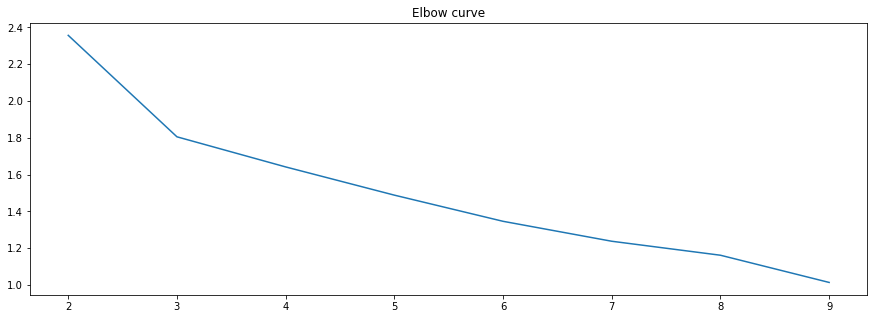

In [59]:
fig = plt.figure(figsize=(15, 5))
plt.plot(distorsions[0], distorsions[1])
plt.title("Elbow curve")

In [60]:
# kmeans with 3 clusters

postal_codes = list(milan_grouped["postal code"])

k_means3 = KMeans(n_clusters = 3, random_state = 0).fit(milan_grouped_clustering)
k_means_labels3 = k_means3.labels_

df_kmeans3 = pd.DataFrame({"postal code": postal_codes, "kmeans3 labels": k_means_labels3})

print(k_means_labels3)

[0 2 0 0 2 2 0 0 0 0 0 2 2 0 0 0 1 2 1 1 2 2 2 2 1 0 0 2 1 2 2 0 2 1 2 2 1
 1]


In [61]:
# adding the labels of the two analysis into the dataframe of Milan neighbourhoods

df_milan_neighbours = df_milan_neighbours.merge(df_kmeans3, on = "postal code", how = "left")
df_milan_neighbours.head()

,postal code,latitude,longitude,radius,kmeans3 labels
0,20131,45.486449,9.221539,0.993299,0
1,20124,45.485790,9.195480,1.099669,0
2,20125,45.499705,9.206106,0.917383,2
3,20142,45.435227,9.156395,0.868316,1
4,20137,45.453002,9.221874,0.557452,0


In [62]:
# printing the map of Milan containing the clusterd neighbours with k = 3

center = [45.47710083803587, 9.181577505485071]
colors = ["red", "blue", "green", "purple", "black"]

milan_map3 = folium.folium.Map(location = center, zoom_start = 12)

for index, row in df_milan_neighbours.iterrows():
    folium.Circle(location = [row["latitude"], row["longitude"]], popup = row["postal code"], radius = 200, color = colors[row["kmeans3 labels"]]).add_to(milan_map3)
    
milan_map3

In [63]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [64]:
#creating a dataframe that shows the most frequent type of restaurant present in each neighbourhood of Milan
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['postal code']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind])) #apply st, nd or rd after 1,2,3, otherwise it prints th
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
df_milan_venues = pd.DataFrame(columns=columns)
df_milan_venues['postal code'] = milan_grouped['postal code']

for ind in np.arange(milan_grouped.shape[0]):
    df_milan_venues.iloc[ind, 1:] = return_most_common_venues(milan_grouped.iloc[ind, :], num_top_venues)

df_milan_venues.head()

,postal code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,20121,Italian Restaurant,Pizza Place,Japanese Restaurant,Mediterranean Restaurant,Tapas Restaurant,Sushi Restaurant,Modern European Restaurant,Eastern European Restaurant,Indian Restaurant,Hawaiian Restaurant
1,20122,Pizza Place,Japanese Restaurant,Italian Restaurant,American Restaurant,Vegetarian / Vegan Restaurant,Bistro,Spanish Restaurant,Burger Joint,Modern European Restaurant,Sardinian Restaurant
2,20123,Italian Restaurant,Pizza Place,Japanese Restaurant,Bistro,Sicilian Restaurant,Korean Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Greek Restaurant,Hawaiian Restaurant
3,20124,Italian Restaurant,Pizza Place,Bistro,Japanese Restaurant,Sushi Restaurant,Ramen Restaurant,Chinese Restaurant,Szechuan Restaurant,Indian Restaurant,Thai Restaurant
4,20125,Pizza Place,Seafood Restaurant,Italian Restaurant,Chinese Restaurant,South American Restaurant,Greek Restaurant,Kebab Restaurant,Japanese Restaurant,Trattoria/Osteria,Bistro


In [65]:
# convert postal codes into integer values

df_milan_venues["postal code"] = df_milan_venues["postal code"].astype("int")

In [66]:
# extracting the labels

k_means_labels3 = list(k_means_labels3)
k_labels3 = []

for lab in k_means_labels3:
    if lab in k_labels3:
        pass
    else:
        k_labels3.append(lab)

k_labels3

[0, 2, 1]

In [67]:
# extract the list of postal codes in cluster 1 (label k = 0)

list_t1 = list(df_milan_neighbours[df_milan_neighbours["kmeans3 labels"] == k_labels3[0]]["postal code"])
list_t1 = [i for i in list_t1]
list_t1

['20131',
 '20124',
 '20137',
 '20155',
 '20128',
 '20123',
 '20149',
 '20121',
 '20127',
 '20148',
 '20135',
 '20129',
 '20132',
 '20136']

In [69]:
#extract from the database the neighbourhoods with postal codes belonging to cluster 1 (label k = 0)

df_label1 = df_milan_venues[df_milan_venues.iloc[:, 0].isin(list_t1)].iloc[:, 0::]
df_label1.head()

,postal code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,20121,Italian Restaurant,Pizza Place,Japanese Restaurant,Mediterranean Restaurant,Tapas Restaurant,Sushi Restaurant,Modern European Restaurant,Eastern European Restaurant,Indian Restaurant,Hawaiian Restaurant
2,20123,Italian Restaurant,Pizza Place,Japanese Restaurant,Bistro,Sicilian Restaurant,Korean Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Greek Restaurant,Hawaiian Restaurant
3,20124,Italian Restaurant,Pizza Place,Bistro,Japanese Restaurant,Sushi Restaurant,Ramen Restaurant,Chinese Restaurant,Szechuan Restaurant,Indian Restaurant,Thai Restaurant
6,20127,Italian Restaurant,Pizza Place,Chinese Restaurant,Indian Restaurant,Greek Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Japanese Restaurant,Hawaiian Restaurant,Fried Chicken Joint
7,20128,Italian Restaurant,Pizza Place,Diner,Trattoria/Osteria,Puglia Restaurant,Vietnamese Restaurant,Indian Restaurant,Hawaiian Restaurant,Greek Restaurant,Fried Chicken Joint


In [70]:
#extract all the restaurants present in the top10 of the most present restaurants of the first cluster (k = 0)
top_restaurant1 = []

for index, row in df_label1.iterrows():
    for i in range(1, len(row)):
        if row[i] not in top_restaurant1:
            top_restaurant1.append(row[i])
            
top_restaurant1 = sorted(top_restaurant1)
top_restaurant1 = ["postal code"] + top_restaurant1

In [71]:
milan_grouped_top1 = milan_grouped[top_restaurant1]
milan_grouped_top1.head()

,postal code,Argentinian Restaurant,Asian Restaurant,Bistro,Brazilian Restaurant,Burger Joint,Campanian Restaurant,Chinese Restaurant,Diner,Eastern European Restaurant,...,Seafood Restaurant,Sicilian Restaurant,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,20121,0.0,0.000,0.000000,0.000,0.000000,0.0,0.00,0.0,0.0,...,0.0,0.000000,0.062500,0.000,0.0625,0.000,0.00,0.0,0.000000,0.0
1,20122,0.0,0.000,0.066667,0.000,0.066667,0.0,0.00,0.0,0.0,...,0.0,0.000000,0.000000,0.000,0.0000,0.000,0.00,0.0,0.066667,0.0
2,20123,0.0,0.000,0.037037,0.000,0.000000,0.0,0.00,0.0,0.0,...,0.0,0.037037,0.037037,0.000,0.0000,0.000,0.00,0.0,0.037037,0.0
3,20124,0.0,0.025,0.100000,0.025,0.025000,0.0,0.05,0.0,0.0,...,0.0,0.000000,0.050000,0.025,0.0000,0.025,0.00,0.0,0.000000,0.0
4,20125,0.0,0.000,0.000000,0.000,0.000000,0.0,0.05,0.0,0.0,...,0.2,0.000000,0.000000,0.000,0.0000,0.000,0.05,0.0,0.000000,0.0


In [72]:
#extract the neighourhood belonging to the first cluster

df_milan1 = milan_grouped_top1[milan_grouped_top1.iloc[:, 0].isin(list_t1)]
df_milan1.head()

,postal code,Argentinian Restaurant,Asian Restaurant,Bistro,Brazilian Restaurant,Burger Joint,Campanian Restaurant,Chinese Restaurant,Diner,Eastern European Restaurant,...,Seafood Restaurant,Sicilian Restaurant,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,20121,0.0,0.000,0.000000,0.000,0.000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.062500,0.000,0.0625,0.000,0.000000,0.0,0.000000,0.0
2,20123,0.0,0.000,0.037037,0.000,0.000,0.0,0.000000,0.000000,0.0,...,0.0,0.037037,0.037037,0.000,0.0000,0.000,0.000000,0.0,0.037037,0.0
3,20124,0.0,0.025,0.100000,0.025,0.025,0.0,0.050000,0.000000,0.0,...,0.0,0.000000,0.050000,0.025,0.0000,0.025,0.000000,0.0,0.000000,0.0
6,20127,0.0,0.000,0.000000,0.000,0.000,0.0,0.105263,0.000000,0.0,...,0.0,0.000000,0.000000,0.000,0.0000,0.000,0.000000,0.0,0.000000,0.0
7,20128,0.0,0.000,0.000000,0.000,0.000,0.0,0.000000,0.090909,0.0,...,0.0,0.000000,0.000000,0.000,0.0000,0.000,0.090909,0.0,0.000000,0.0


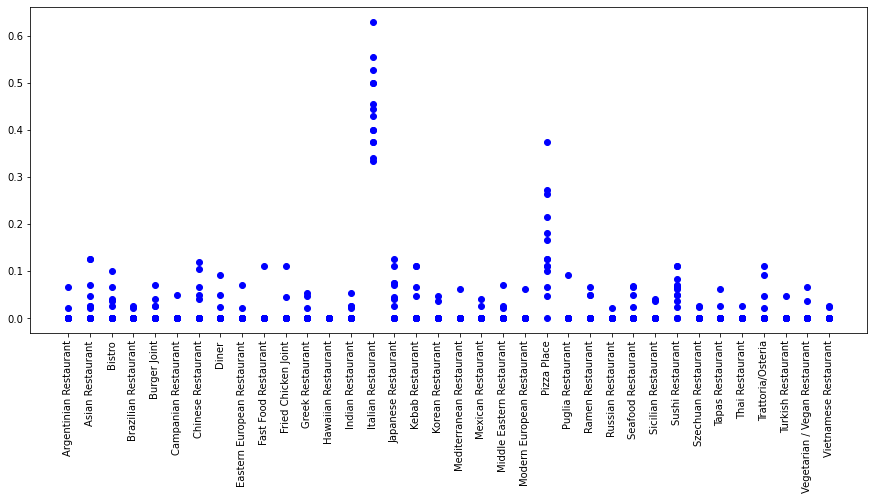

In [73]:
# plot the distribution of restaurant categories for cluster 1

fig = plt.figure(figsize = (15,6))
rest_list1 = top_restaurant1[1:]

for index, row in df_milan1.iterrows():
    values_t = list(row[1:])
    #print(values_t)
    plt.scatter(rest_list1, values_t, color = "blue") #label = row["postal code"])
    #plt.legend()
    plt.xticks(rotation = 90)
plt.show()

In [75]:
# create the dataframe and plot the distribution for cluster 2
# extract the list of postal codes in cluster 2 (label k = 1)

list_t2 = list(df_milan_neighbours[df_milan_neighbours["kmeans3 labels"] == k_labels3[1]]["postal code"])
list_t2 = [i for i in list_t2]

#extract from the database the neighbours with postal codes belonging to cluster 2 (label k = 1)

df_label2 = df_milan_venues[df_milan_venues.iloc[:, 0].isin(list_t2)].iloc[:, 0::]
df_label2.head()

,postal code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,20122,Pizza Place,Japanese Restaurant,Italian Restaurant,American Restaurant,Vegetarian / Vegan Restaurant,Bistro,Spanish Restaurant,Burger Joint,Modern European Restaurant,Sardinian Restaurant
4,20125,Pizza Place,Seafood Restaurant,Italian Restaurant,Chinese Restaurant,South American Restaurant,Greek Restaurant,Kebab Restaurant,Japanese Restaurant,Trattoria/Osteria,Bistro
5,20126,Pizza Place,Italian Restaurant,Trattoria/Osteria,Sushi Restaurant,Puglia Restaurant,Sardinian Restaurant,Seafood Restaurant,Kebab Restaurant,French Restaurant,Dim Sum Restaurant
11,20133,Pizza Place,Seafood Restaurant,Italian Restaurant,Japanese Restaurant,Food Truck,Chinese Restaurant,Trattoria/Osteria,Sushi Restaurant,Fast Food Restaurant,Eastern European Restaurant
12,20134,Pizza Place,Italian Restaurant,Diner,Latin American Restaurant,American Restaurant,Asian Restaurant,Mediterranean Restaurant,Buffet,Chinese Restaurant,Filipino Restaurant


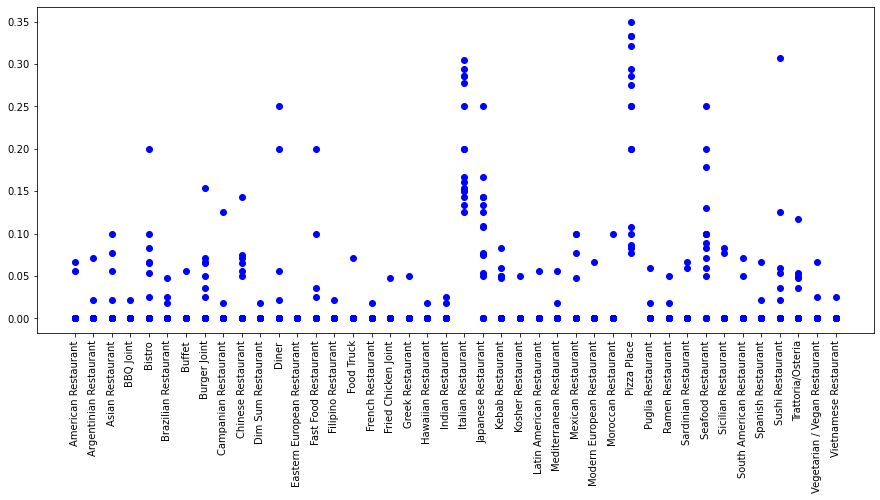

In [76]:
#extract all the restaurants present in the top10 of the most present restaurants of the second cluster (k = 1)
top_restaurant2 = []

for index, row in df_label2.iterrows():
    for i in range(1, len(row)):
        if row[i] not in top_restaurant2:
            top_restaurant2.append(row[i])
            
top_restaurant2 = sorted(top_restaurant2)
top_restaurant2 = ["postal code"] + top_restaurant2

milan_grouped_top2 = milan_grouped[top_restaurant2]

df_milan2 = milan_grouped_top2[milan_grouped_top2.iloc[:, 0].isin(list_t2)]

# plot the distribution of restaurant categories for cluster 2

fig = plt.figure(figsize = (15,6))
rest_list2 = top_restaurant2[1:]

for index, row in df_milan2.iterrows():
    values_t = list(row[1:])
    #print(values_t)
    plt.scatter(rest_list2, values_t, color = "blue") #label = row["postal code"])
    #plt.legend()
    plt.xticks(rotation = 90)
plt.show()

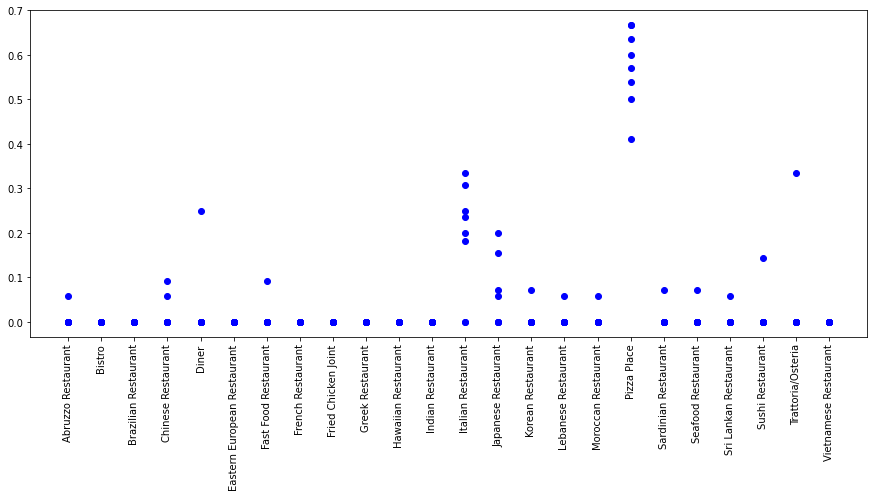

In [77]:
# create the dataframe and plot the distribution for cluster 3
# extract the list of postal codes in cluster 3 (label k = 2)

list_t3 = list(df_milan_neighbours[df_milan_neighbours["kmeans3 labels"] == k_labels3[2]]["postal code"])
list_t3 = [i for i in list_t3]

#extract from the database the neighbours with postal codes belonging to cluster 3 (label k = 2)

df_label3 = df_milan_venues[df_milan_venues.iloc[:, 0].isin(list_t3)].iloc[:, 0::]

#extract all the restaurants present in the top10 of the most present restaurants of the third cluster (k = 2)
top_restaurant3 = []

for index, row in df_label3.iterrows():
    for i in range(1, len(row)):
        if row[i] not in top_restaurant3:
            top_restaurant3.append(row[i])
            
top_restaurant3 = sorted(top_restaurant3)
top_restaurant3 = ["postal code"] + top_restaurant3

milan_grouped_top3 = milan_grouped[top_restaurant3]

df_milan3 = milan_grouped_top3[milan_grouped_top3.iloc[:, 0].isin(list_t3)]

# plot the distribution of restaurant categories for cluster 3

fig = plt.figure(figsize = (15,6))
rest_list3 = top_restaurant3[1:]

for index, row in df_milan3.iterrows():
    values_t = list(row[1:])
    #print(values_t)
    plt.scatter(rest_list3, values_t, color = "blue") #label = row["postal code"])
    #plt.legend()
    plt.xticks(rotation = 90)
    
plt.show()

In [78]:
top_restaurant = []

for t in top_restaurant1:
    if t not in top_restaurant:
        top_restaurant.append(t)

for t in top_restaurant2:
    if t not in top_restaurant:
        top_restaurant.append(t)
        
for t in top_restaurant3:
    if t not in top_restaurant:
        top_restaurant.append(t)

In [79]:
df_milan_t = milan_grouped.merge(df_milan_neighbours[["postal code", "kmeans3 labels"]], on = "postal code", how = "outer")
df_milan_t = df_milan_t[top_restaurant]
df_milan_t.head()

,postal code,Argentinian Restaurant,Asian Restaurant,Bistro,Brazilian Restaurant,Burger Joint,Campanian Restaurant,Chinese Restaurant,Diner,Eastern European Restaurant,...,French Restaurant,Kosher Restaurant,Latin American Restaurant,Moroccan Restaurant,Sardinian Restaurant,South American Restaurant,Spanish Restaurant,Abruzzo Restaurant,Lebanese Restaurant,Sri Lankan Restaurant
0,20121,0.0,0.000,0.000000,0.000,0.000000,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.0,0.0,0.0
1,20122,0.0,0.000,0.066667,0.000,0.066667,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.066667,0.00,0.066667,0.0,0.0,0.0
2,20123,0.0,0.000,0.037037,0.000,0.000000,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.0,0.0,0.0
3,20124,0.0,0.025,0.100000,0.025,0.025000,0.0,0.05,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00,0.000000,0.0,0.0,0.0
4,20125,0.0,0.000,0.000000,0.000,0.000000,0.0,0.05,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.05,0.000000,0.0,0.0,0.0


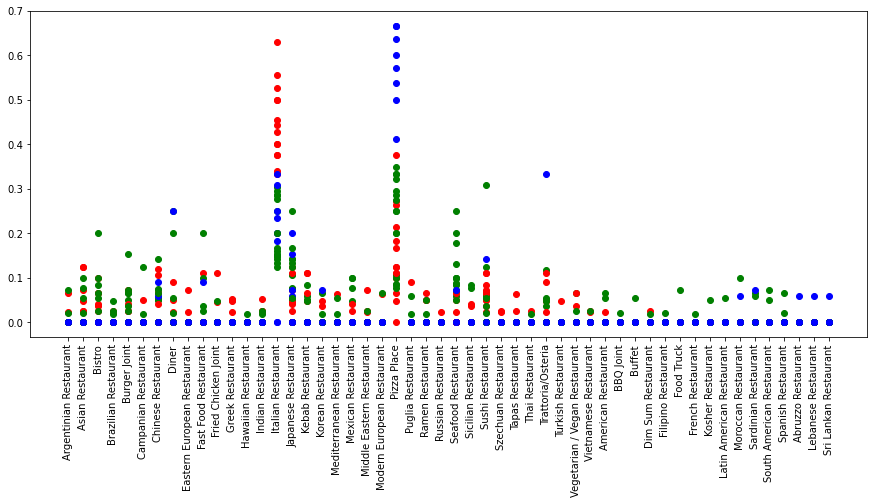

In [80]:
colors = ["red", "blue", "green"]

fig = plt.figure(figsize = (15,6))
rest_list = top_restaurant[1:]

for index, row in df_milan_t.iterrows():
    values_t = list(row[1:])
    #print(values_t)
    plt.scatter(rest_list, values_t, color = colors[int(df_milan_neighbours[df_milan_neighbours["postal code"] == row["postal code"]]["kmeans3 labels"])])
    #plt.legend()
    plt.xticks(rotation = 90)
    
plt.show()